In [ ]:
!pip install qutip
!pip install qiskit
!pip install qiskit_dynamics
!pip install jax

In [2]:
import jax
import jax.numpy as jnp
import jax.scipy as jcp
from jax import jit
import numpy as np
import time
import matplotlib.pyplot as plt
from qutip import *
from qiskit.quantum_info import Operator

In [3]:
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU if using a system without a GPU
jax.config.update('jax_platform_name', 'cpu')
# import Array and set default backend
from qiskit_dynamics.array import Array
Array.set_default_backend("jax")

#from jax import config
#config.update("jax_disable_jit", True)

## Poor Implementation of Quantum Jump (Time-independent)

In [5]:
wr = 6
wd = wr
Nr = 15
a = destroy(Nr)

sz = (a.dag()*a).full()
sx = a.full()
psi0 = coherent(Nr, 0.2).full().reshape(Nr,)
H = -wr/2*sz
Ls = [np.sqrt(0.2)*sx, 0.05*sz]

Heff = H - 1j/2 * sum([L.T.conjugate()@L for L in Ls]) # effective Hamiltonian

In [ ]:
dt = 2*0.2/np.linalg.norm(H, ord ='fro') # timestep
dt

0.004185098803828963

In [8]:
dt = 0.05 # timestep
m = 1000 # number of steps
tf = dt*m # final time
times = np.linspace(0,tf,m)

## Square Pulse
def H1_coeff(t, args):
    T = args['T']
    A = args['A']
    if t>=0 and t<T:
        pulse = A
    else:
        pulse = 0
    return pulse*np.exp(-1j*wd*t)

def H2_coeff(t, args):
    T = args['T']
    A = args['A']
    if t>=0 and t<T:
        pulse = A
    else:
        pulse = 0
    return pulse*np.exp(1j*wd*t)

## Pulse parameters
args = {'A': 2, 'T':20}                                      # Square Pulse

In [36]:
def RK4_evo(dt, Heff, size):
    '''RK4 evolution for time-independent Hamiltonian'''
    k1 = -1j*Heff
    k2 = -1j*Heff*(1+k1/2*dt)
    k3 = -1j*Heff*(1+k2/2*dt)
    k4 = -1j*Heff*(1+k3*dt)
    return np.eye(size)+dt/6*(k1+2*k2+2*k3+k4)

def single_traj(psi0, H, times, c_ops, args):
    t = 0
    waves = [psi0]
    for t in times[1:]:
        # generate a random number in (0,1]
        u = np.random.random()
        # array of jump probabilities
        dps = [np.real(dt * (waves[-1].T.conjugate()@(L.T.conjugate()@L)@waves[-1])) for L in c_ops]
        # renormalisation factor 1-dP
        dP = np.sum(dps)

        # test
        if dP <= u:
            temp = RK4_evo(dt, H, len(psi0))@(waves[-1])
            #temp = (np.eye(len(psi0))-1j*H*dt)@(waves[-1])
            #temp = sp.linalg.expm(-1j*H*dt)@(waves[-1])
        else:
            # new random number
            u = np.random.random()
            Q = np.cumsum(dps)/dP
            # pick the jump that has occurred
            k = np.searchsorted(Q, u, side = 'left')
            temp = c_ops[k]@waves[-1]
        waves.append(temp/np.linalg.norm(temp))
    return waves, np.array([(wave.T.conjugate()@sz@wave) for wave in waves])

from tqdm import tqdm

def my_mcsolve(psi0, H, times, c_ops=[], e_ops=[], args={}, ntraj=150):
    '''Calculate the stochastic dyanmics by MCWF method, using the inaccurate Euler method'''

    mean = np.zeros(m, dtype = complex) #array for the results
    all_results = []
    for count in tqdm(range(ntraj)):
        result, _ = single_traj(psi0, H, times, np.array(c_ops), args)
        all_results.append(result)
        mean += _
    mean = np.array(mean)/ntraj
    return mean, all_results

100%|██████████| 150/150 [00:26<00:00,  5.64it/s]


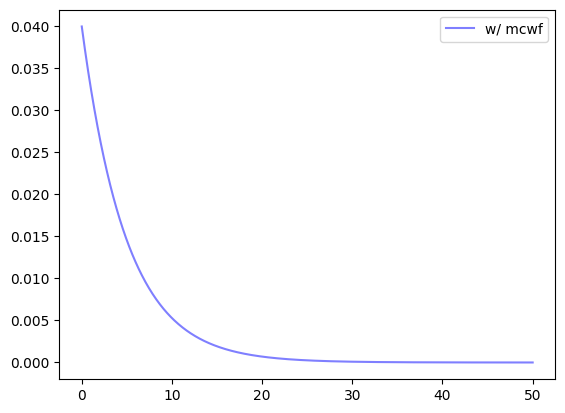

In [37]:
mean, all_results = my_mcsolve(psi0, Heff, times, c_ops=Ls)
fig, ax = plt.subplots()
ax.plot(times, np.real(mean), 'b-', alpha = 0.5, label = 'w/ mcwf');
ax.legend();

#### Time Cost
* ODE solver
* for loop
* list index
* list sum


## Poor Implementation of Quantum Jump (Time-dependent)

In [ ]:
def RK4_evo2(dt, Ht, Ht1, Ht2, size):
    '''RK4 evolution for time-independent Hamiltonian'''
    k1 = -1j*Ht
    k2 = -1j*(Ht1)*(1+k1/2*dt)
    k3 = -1j*(Ht1)*(1+k2/2*dt)
    k4 = -1j*Ht2*(1+k3*dt)
    return np.eye(size)+dt/6*(k1+2*k2+2*k3+k4)

def single_traj2(psi0, H, times, c_ops, args):
    t = 0
    waves = [psi0]
    for t in times[1:]:
        # generate a random number in (0,1]
        u = np.random.random()
        # array of jump probabilities
        dps = [np.real(dt * (waves[-1].T.conjugate()@(L.T.conjugate()@L)@waves[-1])) for L in c_ops]
        # renormalisation factor 1-dP
        dP = np.sum(dps)

        # test
        if dP <= u:
            Ht = H+H1_coeff(t, args)*sx+H2_coeff(t, args)*sx.T
            Ht1 = H+H1_coeff(t+dt/2, args)*sx+H2_coeff(t+dt/2, args)*sx.T
            Ht2 = H+H1_coeff(t+dt, args)*sx+H2_coeff(t+dt, args)*sx.T

            temp = RK4_evo2(dt, Ht, Ht1, Ht2, len(psi0))@(waves[-1])
            #temp = (np.eye(len(psi0))-1j*H*dt)@(waves[-1])
            #temp = sp.linalg.expm(-1j*H*dt)@(waves[-1])
        else:
            # new random number
            u = np.random.random()
            Q = np.cumsum(dps)/dP
            # pick the jump that has occurred
            k = np.searchsorted(Q, u, side = 'left')
            temp = c_ops[k]@waves[-1]
        waves.append(temp/np.linalg.norm(temp))
    return np.array([(wave.T.conjugate()@sz@wave) for wave in waves])

def my_mcsolve2(psi0, H, times, c_ops=[], e_ops=[], args={}, ntraj=150):
    '''Calculate the stochastic dyanmics by MCWF method, using the inaccurate Euler method'''

    mean = np.zeros(m, dtype = complex) #array for the results

    for count in tqdm(range(ntraj)):
        mean += single_traj2(psi0, H, times, np.array(c_ops), args)
    mean = np.array(mean)/ntraj
    return mean

In [ ]:
dt = 0.001 # timestep
m = int(50/dt) # number of steps
tf = dt*m # final time
times = np.linspace(0,tf,m)

mean = my_mcsolve2(psi0, Heff, times, c_ops=Ls, args=args)
fig, ax = plt.subplots()
ax.plot(times, np.real(mean), 'b-', alpha = 0.5, label = 'w/ mcwf');
ax.legend();

## JAX accelerated version (Fork Qiskit_dynamics)

In [58]:
from typing import Callable, Optional, Union, Tuple, List
import numpy as np
from numpy import ndarray
from qiskit_dynamics.array import Array, wrap
from qiskit_dynamics.type_utils import to_array
import jax.numpy as jnp
from jax.lax import scan, cond, fori_loop
from jax import random
from scipy.integrate._ivp.ivp import OdeResult

from qiskit_dynamics.dispatch import requires_backend


class myLindbladModel():
    r'''Hello'''

    def __init__(
        self,
        static_Hamiltonian: Union[Array, ndarray],
        Hamiltonian_operators: Union[Array, ndarray],
        dissipators: Union[List, Array, ndarray],
        signal_funcs: Union[Callable, None],
        signal_args: Union[List[Callable], None]
    ):
        r'''static_Hamiltonian: Union
        '''
        self.static_Hamiltonian = static_Hamiltonian
        self.Hamiltonian_operators = Hamiltonian_operators
        self.dissipators = dissipators
        self.signal_funcs = signal_funcs
        self.signal_args = signal_args
        self._static_Hamiltonian = jnp.array(static_Hamiltonian)

        if Hamiltonian_operators is not None:
            self._Hamiltonian_operators = [jnp.array(H) for H in Hamiltonian_operators]
        if dissipators is not None:
            self._dissipators = jnp.array(dissipators)
            self._conditional_Hamiltonian = jnp.array(static_Hamiltonian - 1j/2*sum([dagger(L)@L for L in dissipators]))
        else:
            self._conditional_Hamiltonian = static_Hamiltonian

        self._ham_sig_vals = None
        self.dtype = None

    @property
    def _conditionial_Hamiltonian(self):
        return self.static_Hamiltonian- 1j/2 * sum([L.T.conjugate()@L for L in self.dissipators])

    def __call__(self, t, y):
        return self.evaluate_rhs(t, y)

    def _signal_val(self, t):
        return jnp.array([func(t, self.signal_args) for func in self.signal_funcs])

    def evaluate_rhs(self, t, y):
        r'''Calculate the -i H(t)\psi(t)'''
        if self.signal_funcs == None:
            return -1j*self._conditional_Hamiltonian@y
        else:
            sig_vals = self._signal_val(t)
            drive_Hamls = jnp.tensordot(sig_vals, np.array(self.Hamiltonian_operators), axes=1)
            return -1j*(self._conditional_Hamiltonian + drive_Hamls)@y

##############################         Helper Functions       ################################
def MC_sampling(dissipators, y, h):
    dps = [jnp.real(h * (dagger(y) @ dagger(L) @ L @ y)) for L in dissipators]
    dP = sum(dps)

    return dP, dps

def collapse_which(dissipators, dP, dps):
    u = np.random.random()
    Q = jnp.cumsum(jnp.array(dps))/dP
    # pick the jump that has occurred
    k = np.searchsorted(Q, u, side = 'left')

    idx = jnp.zeros(len(dissipators))
    idx.at[k].set(1)
    L = jnp.tensordot(idx, dissipators, axes=1)
    return k, L

def dagger(x):
    return jnp.conjugate(jnp.transpose(x))

dt = 0.01 # timestep
m = int(50/dt) # number of steps
tf = dt*m # final time
times = jnp.linspace(0,tf,m)

args = {'A': 2, 'T':20} # Square Pulse

## Square Pulse
def H1_coeff_jax(t, args):
    T = args['T']
    A = args['A']
    def Constant(A):
        return A
    def Zero(A):
        return 0

    pulse = cond(t>=0, lambda A: Constant(A), Zero, A)
    return pulse*jnp.exp(-1j*wd*t)

def H2_coeff_jax(t, args):
    T = args['T']
    A = args['A']
    def Constant(A):
        return A
    def Zero(A):
        return 0

    pulse = cond(t>=0, lambda A: Constant(A), Zero, A)
    return pulse*jnp.exp(1j*wd*t)
###############################################################################################

def _single_traj_jax(
    take_step: Callable,
    jump: Callable,
    rhs_func: Callable,
    dissipators: Union[Array, ndarray],
    t_list: Union[Array, ndarray],
    y0: Union[Array, ndarray],
    h: Union[float, Array],
):
    """This function is the jax control-flow version of
    :meth:`fixed_step_solver_template`. See the documentation of :meth:`fixed_step_solver_template`
    for details.

    Args:
    Returns:
        OdeResult: Results object.
    """
    y0 = Array(y0).data
    h_list = Array([h]*len(t_list)).data

    # interval integrator set up for jax.lax.scan
    def scan_interval_integrate(carry, x):
        current_t, h = x
        current_y = carry

        u = np.random.random()
        dP, dps = MC_sampling(dissipators, current_y, h)

        temp = cond(dP<=u, lambda y: take_step(rhs_func, current_t, y, h), lambda y: jump(dP, dps, y), current_y)
        norm = jnp.linalg.norm(temp)

        next_y = cond(norm==0, lambda y: y, lambda y: y/norm, temp)

        next_t = current_t + h

        return next_y, next_y

    ys = scan(
        scan_interval_integrate,
        init=y0,
        xs=(jnp.array(t_list[:-1]), jnp.array(h_list[:-1])),
    )[1]

    ys = Array(jnp.append(jnp.expand_dims(y0, axis=0), ys, axis=0), backend="jax").data

    results = t_list, ys[:-1] # OdeResult(t=t_list[:-1], y=ys[:-1]) #

    return results

@requires_backend("jax")
def jax_mcwf_solver(
    rhs: Callable,
    dissipators: Union[Array, ndarray],
    t_list: Union[Array, ndarray],
    y0: Union[Array, ndarray],
    dt: float,
    t_eval: Optional[Union[Tuple, List, Array]] = None,
):
    """JAX version of RK4_solver.

    Args:
        rhs: Callable, either a generator rhs
        t_span: Interval to solve over.
        y0: Initial state.
        max_dt: Maximum step size.
        t_eval: Optional list of time points at which to return the solution.

    Returns:
        OdeResult: Results object.
    """
    div6 = 1.0 / 6

    def take_step(rhs_func, t, y, h):

        h2 = 0.5 * h
        t_plus_h2 = t + h2

        k1 = rhs_func(t, y)
        k2 = rhs_func(t_plus_h2, y + h2 * k1)
        k3 = rhs_func(t_plus_h2, y + h2 * k2)
        k4 = rhs_func(t + h, y + h * k3)

        return y + div6 * h * (k1 + 2 * k2 + 2 * k3 + k4)

    def jump(dP, dps, y):
        k, L = collapse_which(dissipators, dP, dps)
        return L@y

    def wrapped_rhs_func(*args):
        return Array(rhs(*args), backend="jax").data

    return _single_traj_jax(
        take_step, jump, rhs_func=wrapped_rhs_func, dissipators=dissipators, t_list=t_list, y0=y0, h=dt,
    )

def mcwf_solve(
    rhs: Callable,
    model: myLindbladModel,
    t_list: Array,
    y0: Array,
    dt: float,
    num_traj: int,
    t_eval: Optional[Union[Tuple, List, Array]] = None,
):
    r''' jit-complied '''

    y0 = Array(y0)

    def sample_a_traj(t_list, y0, dt):
        _, result_y = jax_mcwf_solver(rhs=model, dissipators=model._dissipators, t_list=t_list, y0=y0, dt=dt)
        return Array(result_y).data

    jit_sample_a_traj = jit(sample_a_traj)

    def get_ave_state(A):
        all_trajs = Array(A)
        ave_trajs = Array(np.sum(A, axis=0)/num_traj)

        return ave_trajs, all_trajs

    all_results = []

    def sample_all_trajs(i, val):
        result_y = jit_sample_a_traj(t_list, y0, dt)
        all_results.append(result_y)

    #fori_loop(0, num_traj, sample_all_trajs, 0)

    for i in range(num_traj):
        result_y = jit_sample_a_traj(t_list=Array(t_list).data, y0=Array(y0).data, dt=dt)
        all_results.append(result_y)

    ave_trajs, all_trajs = get_ave_state(all_results)

    return OdeResult(t=t_list[:-1], y=Array(ave_trajs, backend="jax", dtype=complex)), all_trajs

In [59]:
from qutip import *

wr = 6
wd = wr
Nr = 15
a = destroy(Nr)

sz = (a.dag()*a).full()
sx = a.full()
psi0 = coherent(Nr, 0.2).full().reshape(Nr,)
H = -wr/2*sz
Ls = [np.sqrt(0.2)*sx, 0.05*sz]

model = myLindbladModel(
        static_Hamiltonian = -wr/2*sz,
        Hamiltonian_operators = [sx, sx.T.conjugate()],
        dissipators = [np.sqrt(0.2)*sx, 0.05*sz],
        signal_funcs = None,#[H1_coeff_jax, H2_coeff_jax],
        signal_args = args,
    )

## JAX - Time-independent

In [61]:
result, all_trajs = mcwf_solve(rhs=model, model=model, t_list=times, y0=psi0, dt=dt, num_traj=150)

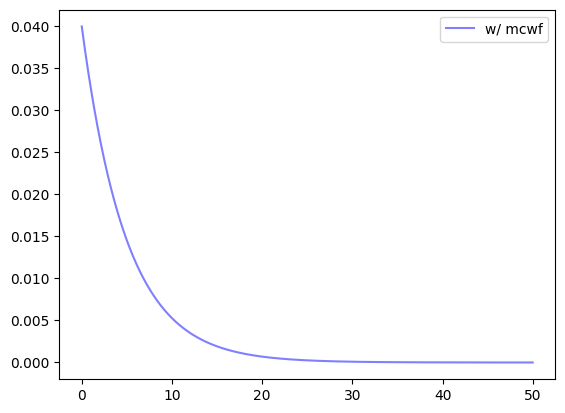

In [62]:
mean = [np.conjugate(psi)@sz@psi  for psi in result.y]

fig, ax = plt.subplots()
ax.plot(result.t, np.real(mean), 'b-', alpha = 0.5, label = 'w/ mcwf');
ax.legend();

## JAX - Time-dependent

In [63]:
model2 = myLindbladModel(
        static_Hamiltonian = -wr/2*sz,
        Hamiltonian_operators = [sx, sx.T.conjugate()],
        dissipators = [np.sqrt(0.2)*sx, 0.05*sz],
        signal_funcs = [H1_coeff_jax, H2_coeff_jax],
        signal_args = args,
    )

result2, all_trajs2 = mcwf_solve(rhs=model2, model=model2, t_list=times, y0=psi0, dt=dt, num_traj=150)

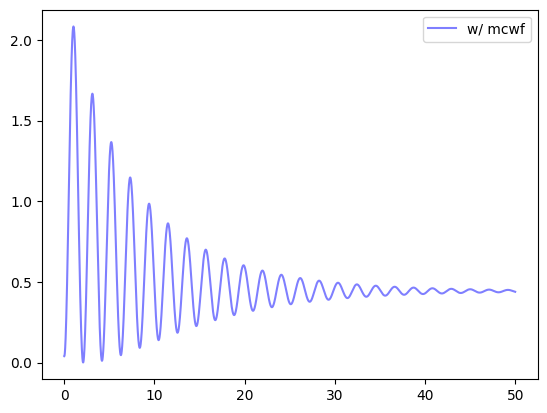

In [64]:
mean2 = [np.conjugate(psi)@sz@psi  for psi in result2.y]

fig, ax = plt.subplots()
ax.plot(result2.t, np.real(mean2), 'b-', alpha = 0.5, label = 'w/ mcwf');
ax.legend();

## QuTip Benchmaraking (Time-independent)

10.0%. Run time:   3.61s. Est. time left: 00:00:00:32
20.0%. Run time:   6.91s. Est. time left: 00:00:00:27
30.0%. Run time:   9.97s. Est. time left: 00:00:00:23
40.0%. Run time:  12.00s. Est. time left: 00:00:00:18
50.0%. Run time:  13.78s. Est. time left: 00:00:00:13
60.0%. Run time:  15.60s. Est. time left: 00:00:00:10
70.0%. Run time:  17.43s. Est. time left: 00:00:00:07
80.0%. Run time:  20.01s. Est. time left: 00:00:00:05
90.0%. Run time:  23.08s. Est. time left: 00:00:00:02
100.0%. Run time:  25.08s. Est. time left: 00:00:00:00
Total run time:  25.12s


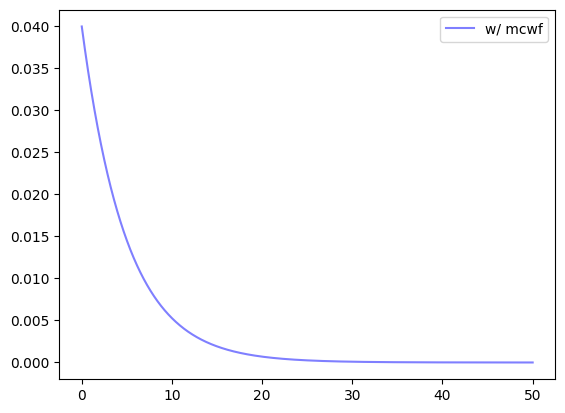

In [36]:
a = destroy(Nr)

sz = (a.dag()*a)
psi0 = coherent(Nr, 0.2)
H0 = -wr/2*sz
c_ops = [np.sqrt(0.2)*a, 0.05*sz]
e_ops = [a.dag()*a]


times = np.linspace(0, 50, 5000)

mcResult = mcsolve(H0, psi0, times,
                    c_ops=c_ops,
                    e_ops=e_ops,
                    progress_bar=True,
                    ntraj=150,
                    options=Options(rhs_with_state=True, store_states=True))#, atol=10e-12, rtol=1e-8))
nc = mcResult.expect[0]

fig, ax = plt.subplots()
ax.plot(times, nc, 'b-', alpha = 0.5, label = 'w/ mcwf');
ax.legend();

## QuTip Benchmarking (Time-dependent)

10.0%. Run time:   5.37s. Est. time left: 00:00:00:48
20.0%. Run time:  11.50s. Est. time left: 00:00:00:46
30.0%. Run time:  17.84s. Est. time left: 00:00:00:41
40.0%. Run time:  23.32s. Est. time left: 00:00:00:34
50.0%. Run time:  31.17s. Est. time left: 00:00:00:31
60.0%. Run time:  36.49s. Est. time left: 00:00:00:24
70.0%. Run time:  42.36s. Est. time left: 00:00:00:18
80.0%. Run time:  49.05s. Est. time left: 00:00:00:12
90.0%. Run time:  54.04s. Est. time left: 00:00:00:06
100.0%. Run time:  61.38s. Est. time left: 00:00:00:00
Total run time:  61.48s


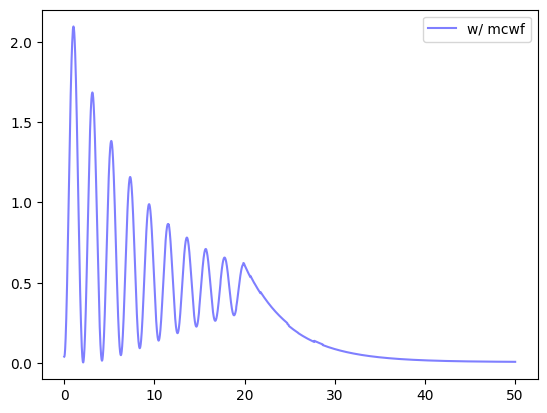

In [37]:
H = [H0, [a,  H1_coeff], [a.dag(), H2_coeff]]

mcResult = mcsolve(H, psi0, times,
                    c_ops=c_ops,
                    e_ops=e_ops,
                    args=args,
                    ntraj=150,
                    progress_bar=True,
                    options=Options(rhs_with_state=True, store_states=True))#, atol=10e-12, rtol=1e-8))
nc = mcResult.expect[0]

fig, ax = plt.subplots()
ax.plot(times, nc, 'b-', alpha = 0.5, label = 'w/ mcwf')
ax.legend();

### Trial: Tensor Contraction

In [ ]:
a = np.random.random([2,2,2])

In [ ]:
a

array([[[0.05939761, 0.31578226],
        [0.58107567, 0.67418658]],

       [[0.43874943, 0.04930135],
        [0.42797084, 0.88057659]]])

In [ ]:
b = np.array([1,0])

In [ ]:
(a@b)

array([[0.05939761, 0.58107567],
       [0.43874943, 0.42797084]])